In [32]:
import sys
import os
from tempfile import NamedTemporaryFile
from gc import collect

sys.path.append('../util')
from meters import ThroughputMeter
import ncgen

import netCDF4
import h5py
import numpy as np
import pylab as pl

os.environ['TMPDIR'] = os.getenv('HOME') + '/tmp/'

## Test throughput reading data via h5py, followed by via python-netcdf4:

In [43]:
results = []
for num_vars in range(1, 20, 2):
    print("Creating a NetCDF file with {} variables".format(num_vars))
    with NamedTemporaryFile(suffix='.nc', delete=False) as f:
        nc = ncgen.make_multivariable_nc(f.name, num_vars=num_vars, unlim=True)
        nc.close()
    for read_with_h5py in [True, False]:
        if read_with_h5py:
            print("Reading out with h5py module...")
            nc = h5py.File(f.name, 'r')
            with ThroughputMeter() as t:
                a = nc['var_0'][:, :, :]
            nc.close()
        else:
            print("Reading out with python-netCDF4 module...")
            nc = netCDF4.Dataset(f.name, 'r')
            with ThroughputMeter() as t:
                a = nc.variables['var_0'][:, :, :]
            nc.close()
        results.append((read_with_h5py, num_vars, t.megabytes_per_second(a)))
        del a
# python-netCDF4 seems to leak file descriptors
    # We have to take a lot of steps to make sure that the files get closed and that
    # the space gets reclaimed by the OS
    f.close()
    del nc
    print("Removing {}".format(f.name))
    os.remove(f.name)
#    f.close()
    collect()

Creating a NetCDF file with 1 variables
Reading out with h5py module...
353.100 MB in 0.132 seconds at 2679.543 MB / sec
Reading out with python-netCDF4 module...
353.100 MB in 0.17 seconds at 2071.501 MB / sec
Removing /tmp/tmpowifah0j.nc
Creating a NetCDF file with 3 variables
Reading out with h5py module...
353.100 MB in 0.132 seconds at 2682.183 MB / sec
Reading out with python-netCDF4 module...
353.100 MB in 0.174 seconds at 2027.550 MB / sec
Removing /tmp/tmpbrx6sm6d.nc
Creating a NetCDF file with 5 variables
Reading out with h5py module...
353.100 MB in 0.132 seconds at 2668.640 MB / sec
Reading out with python-netCDF4 module...
353.100 MB in 0.17 seconds at 2073.468 MB / sec
Removing /tmp/tmpcpvcdwdx.nc
Creating a NetCDF file with 7 variables
Reading out with h5py module...
353.100 MB in 0.131 seconds at 2692.266 MB / sec
Reading out with python-netCDF4 module...
353.100 MB in 0.171 seconds at 2061.760 MB / sec
Removing /tmp/tmpqaip40wz.nc
Creating a NetCDF file with 9 variable

In [44]:
results

[(True, 1, 2679.5426888290222),
 (False, 1, 2071.5012084862592),
 (True, 3, 2682.1826084594277),
 (False, 3, 2027.5495658792895),
 (True, 5, 2668.6404056457409),
 (False, 5, 2073.467531703875),
 (True, 7, 2692.2658367524273),
 (False, 7, 2061.7597122181974),
 (True, 9, 2673.4529070271205),
 (False, 9, 2062.213310608719),
 (True, 11, 2614.3528493833087),
 (False, 11, 2051.0067471000766),
 (True, 13, 206.10492845786965),
 (False, 13, 1293.2404812821617),
 (True, 15, 206.32679801208391),
 (False, 15, 1227.8208733485435),
 (True, 17, 218.10853857549176),
 (False, 17, 1227.6855051763971),
 (True, 19, 203.54579688951682),
 (False, 19, 1226.1019836923451)]

In [53]:
h5py_result_indices = [0,2,4,6,8,10,12,14,16,18]
python_netcdf4_indices = [1,3,5,7,9,11,13,15,17,19]

In [45]:
a = np.array([results[ind] for ind in h5py_result_indices])

In [46]:
b = np.array([results[ind] for ind in python_netcdf4_indices])

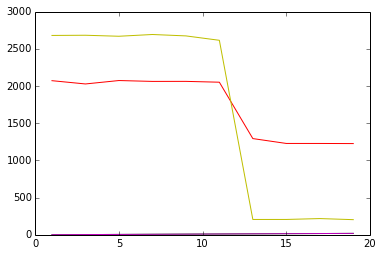

In [47]:
%matplotlib inline
pl.plot(range(1, 20, 2), a)
pl.plot(range(1, 20, 2), b)

h5py is in yellow, python-netcdf4 is in red

In [48]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       1871       5810        374         42        960
-/+ buffers/cache:        868       6812
Swap:            0          0          0


In [49]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
/dev/sda1       107G   36G   66G  35% /
none            4.0K     0  4.0K   0% /sys/fs/cgroup
udev            3.8G  4.0K  3.8G   1% /dev
tmpfs           769M  1.3M  767M   1% /run
none            5.0M     0  5.0M   0% /run/lock
none            3.8G  156K  3.8G   1% /run/shm
none            100M   32K  100M   1% /run/user


## and with the order reversed (python-netcdf4 read followed by hdf5 read)...

In [50]:
results = []
for num_vars in range(1, 20, 2):
    print("Creating a NetCDF file with {} variables".format(num_vars))
    with NamedTemporaryFile(suffix='.nc', delete=False) as f:
        nc = ncgen.make_multivariable_nc(f.name, num_vars=num_vars, unlim=True)
        nc.close()
    for read_with_h5py in [False, True]:
        if read_with_h5py:
            print("Reading out with h5py module...")
            nc = h5py.File(f.name, 'r')
            with ThroughputMeter() as t:
                a = nc['var_0'][:, :, :]
            nc.close()
        else:
            print("Reading out with python-netCDF4 module...")
            nc = netCDF4.Dataset(f.name, 'r')
            with ThroughputMeter() as t:
                a = nc.variables['var_0'][:, :, :]
            nc.close()
        results.append((read_with_h5py, num_vars, t.megabytes_per_second(a)))
        del a
# python-netCDF4 seems to leak file descriptors
    # We have to take a lot of steps to make sure that the files get closed and that
    # the space gets reclaimed by the OS
    f.close()
    del nc
    print("Removing {}".format(f.name))
    os.remove(f.name)
#    f.close()
    collect()

Creating a NetCDF file with 1 variables
Reading out with python-netCDF4 module...
353.100 MB in 0.18 seconds at 1956.445 MB / sec
Reading out with h5py module...
353.100 MB in 0.127 seconds at 2776.370 MB / sec
Removing /tmp/tmprsakcrh2.nc
Creating a NetCDF file with 3 variables
Reading out with python-netCDF4 module...
353.100 MB in 0.18 seconds at 1963.271 MB / sec
Reading out with h5py module...
353.100 MB in 0.127 seconds at 2789.112 MB / sec
Removing /tmp/tmp3vowd0t4.nc
Creating a NetCDF file with 5 variables
Reading out with python-netCDF4 module...
353.100 MB in 0.181 seconds at 1955.089 MB / sec
Reading out with h5py module...
353.100 MB in 0.127 seconds at 2789.133 MB / sec
Removing /tmp/tmp5cyowfs6.nc
Creating a NetCDF file with 7 variables
Reading out with python-netCDF4 module...
353.100 MB in 0.184 seconds at 1920.632 MB / sec
Reading out with h5py module...
353.100 MB in 0.125 seconds at 2831.911 MB / sec
Removing /tmp/tmpi4obozgk.nc
Creating a NetCDF file with 9 variable

In [51]:
results

[(False, 1, 1956.4450209976631),
 (True, 1, 2776.3699658626292),
 (False, 3, 1963.2711832726416),
 (True, 3, 2789.1120837068452),
 (False, 5, 1955.0890940629481),
 (True, 5, 2789.1330942839063),
 (False, 7, 1920.6324438726813),
 (True, 7, 2831.911061990053),
 (False, 9, 1942.1162536357128),
 (True, 9, 2764.4247001332742),
 (False, 11, 1964.4977622611377),
 (True, 11, 2820.5903212904946),
 (False, 13, 247.12876679687167),
 (True, 13, 1947.3614895071794),
 (False, 15, 212.99100006040229),
 (True, 15, 1794.2969988987118),
 (False, 17, 198.95661276236518),
 (True, 17, 1880.8210041324519),
 (False, 19, 202.39402654970053),
 (True, 19, 2026.9751412785072)]

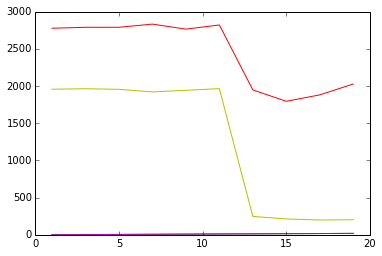

In [52]:
python_netcdf4_indices = [0,2,4,6,8,10,12,14,16,18]
h5py_result_indices = [1,3,5,7,9,11,13,15,17,19]
a = np.array([results[ind] for ind in h5py_result_indices])
b = np.array([results[ind] for ind in python_netcdf4_indices])
%matplotlib inline
pl.plot(range(1, 20, 2), a)
pl.plot(range(1, 20, 2), b)

The throughput for readout via h5py is in red, via python-netcdf4 is in yellow.

h5py has an overall average higher read throughput at < 13 variables (~2700MB/sec), but at >=13 variables both suffer a significant performance hit. The order the test is run (i.e. h5py then python-netcdf4, or vice-versa) may have some effect.  What follows are standalone tests:

## h5py read out only

In [54]:
results = []
for num_vars in range(1, 20, 2):
    print("Creating a NetCDF file with {} variables".format(num_vars))
    with NamedTemporaryFile(suffix='.nc', delete=False) as f:
        nc = ncgen.make_multivariable_nc(f.name, num_vars=num_vars, unlim=True)
        nc.close()
        print("Reading out with h5py module...")
        nc = h5py.File(f.name, 'r')
        with ThroughputMeter() as t:
            a = nc['var_0'][:, :, :]
        nc.close()
        results.append((read_with_h5py, num_vars, t.megabytes_per_second(a)))
        del a
# python-netCDF4 seems to leak file descriptors
    # We have to take a lot of steps to make sure that the files get closed and that
    # the space gets reclaimed by the OS
        f.close()
        del nc
        print("Removing {}".format(f.name))
        os.remove(f.name)
        collect()

Creating a NetCDF file with 1 variables
Reading out with h5py module...
353.100 MB in 0.132 seconds at 2681.323 MB / sec
Removing /tmp/tmpvgrr40zc.nc
Creating a NetCDF file with 3 variables
Reading out with h5py module...
353.100 MB in 0.135 seconds at 2608.289 MB / sec
Removing /tmp/tmpsknfzf7_.nc
Creating a NetCDF file with 5 variables
Reading out with h5py module...
353.100 MB in 0.133 seconds at 2652.467 MB / sec
Removing /tmp/tmp29ft_9r7.nc
Creating a NetCDF file with 7 variables
Reading out with h5py module...
353.100 MB in 0.133 seconds at 2664.789 MB / sec
Removing /tmp/tmpytbfyu4n.nc
Creating a NetCDF file with 9 variables
Reading out with h5py module...
353.100 MB in 0.132 seconds at 2668.943 MB / sec
Removing /tmp/tmpdcu7sn_3.nc
Creating a NetCDF file with 11 variables
Reading out with h5py module...
353.100 MB in 0.133 seconds at 2655.525 MB / sec
Removing /tmp/tmpiyzb8cgt.nc
Creating a NetCDF file with 13 variables
Reading out with h5py module...
353.100 MB in 1.65 seconds

In [55]:
results

[(True, 1, 2681.3230933008895),
 (True, 3, 2608.2889990982867),
 (True, 5, 2652.4665667295303),
 (True, 7, 2664.7894358987278),
 (True, 9, 2668.9433848016956),
 (True, 11, 2655.5246831675358),
 (True, 13, 214.55034686432822),
 (True, 15, 201.55886292513944),
 (True, 17, 206.52987605061617),
 (True, 19, 228.1183960938192)]

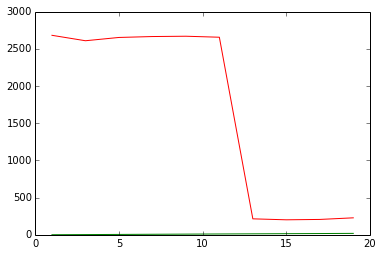

In [61]:
a = np.array(results)
%matplotlib inline
pl.plot(range(1, 20, 2), a)

In [57]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       1886       5795        372         42        957
-/+ buffers/cache:        885       6795
Swap:            0          0          0


In [58]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
/dev/sda1       107G   36G   66G  35% /
none            4.0K     0  4.0K   0% /sys/fs/cgroup
udev            3.8G  4.0K  3.8G   1% /dev
tmpfs           769M  1.3M  767M   1% /run
none            5.0M     0  5.0M   0% /run/lock
none            3.8G  156K  3.8G   1% /run/shm
none            100M   32K  100M   1% /run/user


## python-netcdf4 read out only

In [62]:
results = []
for num_vars in range(1, 20, 2):
    print("Creating a NetCDF file with {} variables".format(num_vars))
    with NamedTemporaryFile(suffix='.nc', delete=False) as f:
        nc = ncgen.make_multivariable_nc(f.name, num_vars=num_vars, unlim=True)
        nc.close()
        print("Reading out with python-netCDF4 module...")
        nc = netCDF4.Dataset(f.name, 'r')
        with ThroughputMeter() as t:
            a = nc.variables['var_0'][:, :, :]
        nc.close()
        results.append((num_vars, t.megabytes_per_second(a)))
        del a
# python-netCDF4 seems to leak file descriptors
    # We have to take a lot of steps to make sure that the files get closed and that
    # the space gets reclaimed by the OS
        f.close()
        del nc
        print("Removing {}".format(f.name))
        os.remove(f.name)
        collect()

Creating a NetCDF file with 1 variables
Reading out with python-netCDF4 module...
353.100 MB in 0.182 seconds at 1944.623 MB / sec
Removing /tmp/tmpmj2yg5sz.nc
Creating a NetCDF file with 3 variables
Reading out with python-netCDF4 module...
353.100 MB in 0.179 seconds at 1969.642 MB / sec
Removing /tmp/tmpugh3t7u0.nc
Creating a NetCDF file with 5 variables
Reading out with python-netCDF4 module...
353.100 MB in 0.186 seconds at 1894.031 MB / sec
Removing /tmp/tmpu98z2zks.nc
Creating a NetCDF file with 7 variables
Reading out with python-netCDF4 module...
353.100 MB in 0.181 seconds at 1951.338 MB / sec
Removing /tmp/tmphkhagdxt.nc
Creating a NetCDF file with 9 variables
Reading out with python-netCDF4 module...
353.100 MB in 0.181 seconds at 1955.593 MB / sec
Removing /tmp/tmpze1xinwi.nc
Creating a NetCDF file with 11 variables
Reading out with python-netCDF4 module...
353.100 MB in 0.182 seconds at 1939.458 MB / sec
Removing /tmp/tmphy8p3z4x.nc
Creating a NetCDF file with 13 variable

In [63]:
results

[(1, 1944.6229800509723),
 (3, 1969.6420748566663),
 (5, 1894.0311586399876),
 (7, 1951.3384718763587),
 (9, 1955.5925046116629),
 (11, 1939.4584995920741),
 (13, 196.28241625766969),
 (15, 191.68368233784074),
 (17, 192.53552951882608),
 (19, 211.34443934994141)]

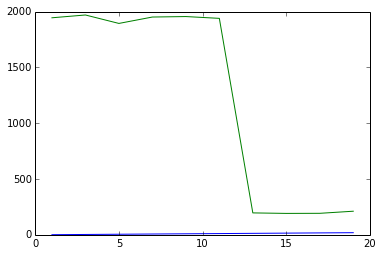

In [64]:
b = np.array(results)
%matplotlib inline
pl.plot(range(1, 20, 2), b)

In [65]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       1890       5790        375         42        960
-/+ buffers/cache:        887       6794
Swap:            0          0          0


In [66]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
/dev/sda1       107G   36G   66G  35% /
none            4.0K     0  4.0K   0% /sys/fs/cgroup
udev            3.8G  4.0K  3.8G   1% /dev
tmpfs           769M  1.3M  767M   1% /run
none            5.0M     0  5.0M   0% /run/lock
none            3.8G  156K  3.8G   1% /run/shm
none            100M   32K  100M   1% /run/user


## Summary
NetCDF file readout using hdf5 appears to be faster than with python-netcdf4, even after suffering a ~10x performance hit at >= 13 variables

In [72]:
hdf5_small_file_avg_throughput = np.average([2681, 2608, 2652, 2664, 2668, 2655])
hdf5_large_file_avg_throughput = np.average([214, 201, 206, 228])
python_netcdf4_small_file_avg_throughput = np.average([1944, 1969, 1894, 1951, 1955, 1939])
python_netcdf4_large_file_avg_throughput = np.average([196, 191, 192, 211])
percent_diff_small = (1 - (python_netcdf4_small_file_avg_throughput / hdf5_small_file_avg_throughput)) * 100
percent_diff_large = (1 - (python_netcdf4_large_file_avg_throughput / hdf5_large_file_avg_throughput)) * 100
print('hdf5 is {0:2.1f}% faster than python-netcdf4 for reading from NetCDF files with small numbers of variables (<13)'.format(percent_diff_small))
print('hdf5 is {0:2.1f}% faster than python-netcdf4 for reading from NetCDF files with large numbers of variables (>13)'.format(percent_diff_large))


hdf5 is 26.8% faster than python-netcdf4 for reading from NetCDF files with small numbers of variables (<13)
hdf5 is 6.9% faster than python-netcdf4 for reading from NetCDF files with large numbers of variables (>13)
